# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# All available features

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model

In [4]:
def targets_corr(df, target_list, target_var, plot_corr=True, print_top_coefs=True, print_top=10,
                 fig_height=4, fig_width=10, legend_loc='center right',
                 output='show', save_path='targets_corr.png', dpi=300, save_only=False):
    target0_corr = df.corr()[target_list[0]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target1_corr = df.corr()[target_list[1]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target2_corr = df.corr()[target_list[2]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target3_corr = df.corr()[target_list[3]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

    all_targets_corr = pd.merge(
        pd.merge(
            pd.merge(target0_corr, target1_corr, on='var'),
            target2_corr, on='var'),
        target3_corr, on='var')
    target_list.append(target_var)
    mask1 = all_targets_corr['var'].isin(target_list)
    all_targets_corr = all_targets_corr[~mask1]
    targets_corr_tidy = pd.melt(all_targets_corr, id_vars='var').sort_values('var')

    if print_top_coefs:
        print("----- Pearson correlation coefficient between features and target classes"
              "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
              targets_corr_tidy.sort_values('value').head(print_top),
              "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
              targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

    if plot_corr:
        # plot univariate Pearson correlation coefficients with target classes
        f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
        sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
                    palette="muted", ax=ax)
        ax.set_ylabel("Features", fontsize=16)
        ax.set_xlabel("Correlation coefficient", fontsize=16)
        ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
        ax.grid(True)
        ax.legend(loc=legend_loc, fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        if output == 'show':
            plt.show()
        if output == 'save':
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
            if save_only:
                f.close()

## Load Teranet data

In [5]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [6]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 111.69 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [7]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [8]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.19 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [9]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [10]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.02 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [11]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 59.17 seconds (0.99 minutes)
with 5,188,513 rows
and 111 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=111)


## Join TTS data to Teranet data

In [12]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 67.06 seconds (1.12 minutes)
with 5,188,513 rows
and 117 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)


## Take a train-test subset of Teranet records

In [13]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features

In [14]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)

In [15]:
all_feat_cols = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
                 'xy_first_sale', 'pin_years_since_last_sale',
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
                 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
                 'outlier_xy_10', 
                 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
                 'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
                 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
                 'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
                 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
                 'Usl_wkpl', 'Blue_cljob', 'White_cljob',
                 'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars',
                 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

85,928 rows in train-test subset, 93,964 rows in validation subset #1, 78,408 rows in validation subset #2


In [16]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cl

In [17]:
feat_set_name = 'all_features_'

## Exploratory Data Analysis (EDA)

In [18]:
print("Pairplot of {0} features would produce {1:.0f} subplots.".format(len(feat_cols), len(feat_cols) ** 2))

Pairplot of 64 features would produce 4096 subplots.


Kernel dies after 3 hours when trying to plot.

In [ ]:
#t = time()
#pg = sns.pairplot(s[feat_cols.append(pd.Index(['lucr']))], hue='lucr')
#pg.savefig('../../results/plots/' + feat_set_name + '_pairplot.png', dpi=400)
#elapsed = time() - t
#print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))
#plt.close()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                           var               variable     value
74            xy_sale_next_6m          lucr_detached -0.708156
7       xy_years_to_next_sale             lucr_condo -0.483833
6    xy_years_since_last_sale             lucr_condo -0.398631
96                   Avg_rent          lucr_detached -0.397323
138           xy_sale_next_6m  lucr_duplex_townhouse -0.347074
102                 Apt_5plus          lucr_detached -0.339114
65             xy_total_sales          lucr_detached -0.330403
67              xy_prev_sales          lucr_detached -0.329369
105                    Rented          lucr_detached -0.301056
99                       Dwel          lucr_detached -0.277466 

         strongest positive correlation (top 10):
                           var               variable     value
71      xy_years_to_next_sale          lucr_detached  0.661756
70

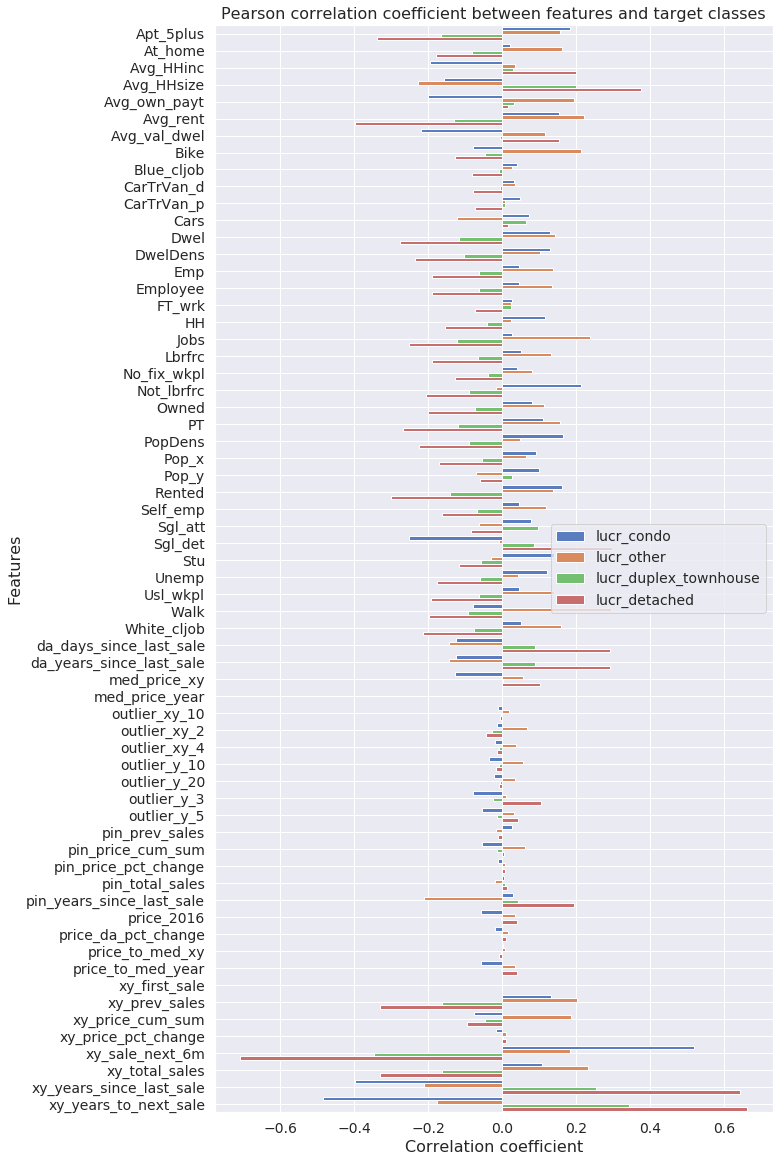

In [28]:
target_list = ['lucr_condo', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_other']
target_var = 'lucr'
save_path = '../../results/plots/' + feat_set_name + '_lucr_corr.png'
targets_corr(s, target_list, target_var, fig_height=20, output='save')

## Encode target

In [14]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               41594
detached            50365
duplex_townhouse    12247
other               33010
Name: lucr, dtype: int64
0    41594
1    50365
2    12247
3    33010
Name: lucr_e, dtype: int64
condo               45697
detached            50909
duplex_townhouse    12639
other               31715
Name: lucr, dtype: int64
0    45697
1    50909
2    12639
3    31715
Name: lucr_e, dtype: int64
condo               39722
detached            48344
duplex_townhouse    11594
other               33002
Name: lucr, dtype: int64
0    39722
1    48344
2    11594
3    33002
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

#### Select features and target

In [18]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [41594 50365 12247 33010]
Labels counts in y_train: [29116 35255  8573 23107]
Labels counts in y_test: [12478 15110  3674  9903]
Labels counts in y_val1: [45697 50909 12639 31715]
Labels counts in y_val2: [39722 48344 11594 33002]


#### Standardize features

In [20]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [21]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Train and test classification algorithms

In [22]:
scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])

#### Perceptron learning algorithm
##### Model accuracy as a function of learning rate $\eta$

In [23]:
def fit_model(model, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_coefs=False, return_scores=False, verbose=True,
              feat_names=None, class_names=None, plot_dec_reg=None):
    t = time()

    # fit the model
    model.fit(X_train, y_train)

    # make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_val1 = model.predict(X_val1)
    y_pred_val2 = model.predict(X_val2)

    # score model performance
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    val1_score = accuracy_score(y_val1, y_pred_val1)
    val2_score = accuracy_score(y_val2, y_pred_val2)

    elapsed = time() - t
    if verbose:
        print("\n{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60) +
              "\naccuracy: train={0:.2f}, test={1:.2f}, validation #1={2:.2f}, validation #2={3:.2f}"
              .format(train_score, test_score, val1_score, val2_score))

    if plot_dec_reg == 'train-test':
        X_combined = np.vstack((X_train, X_test))
        y_combined = np.hstack((y_train, y_test))
        plot_decision_regions(X=X_combined,
                              y=y_combined,
                              classifier=model)
    elif plot_dec_reg == 'val1':
        plot_decision_regions(X=X_val1,
                              y=y_val1,
                              classifier=model)
    elif plot_dec_reg == 'val2':
        plot_decision_regions(X=X_val2,
                              y=y_val2,
                              classifier=model)

    if return_coefs:
        if feat_names is None:
            feat_names = range(X_train.shape[1])
        if class_names is None:
            class_names = range(model.coef_.shape[0])
        coef_df = pd.DataFrame()
        for cl in range(model.coef_.shape[0]):
            class_coef = pd.DataFrame(model.coef_[cl], index=feat_names).reset_index() \
                .rename(columns={'index': 'var', 0: 'coefficient'})
            class_coef['class'] = class_names[cl]
            coef_df = coef_df.append(class_coef)
        return coef_df
    elif return_scores:
        return train_score, test_score, val1_score, val2_score

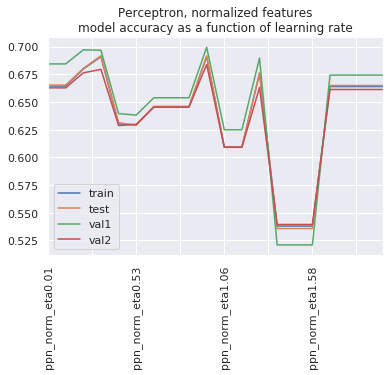

In [24]:
ppn_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Perceptron (normalized features)'
for eta in np.round(np.linspace(0.01, 2, 20), 2):
    scores_name = 'ppn_norm_eta{0}'.format(eta)
    ppn = Perceptron(max_iter=100, eta0=eta, random_state=1)
    ppn_norm_scores_df.loc[scores_name] = \
        fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
ppn_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Perceptron, normalized features\nmodel accuracy as a function of learning rate");

##### Best learning rates

In [25]:
mask1 = ppn_norm_scores_df['val1'] > 0.63
ppn_norm_scores_df[mask1]

,train,test,val1,val2
ppn_norm_eta0.01,0.664387,0.665250,0.684357,0.662744
ppn_norm_eta0.11,0.664387,0.665250,0.684357,0.662744
ppn_norm_eta0.22,0.679764,0.680287,0.697077,0.676298
ppn_norm_eta0.32,0.690914,0.691753,0.696673,0.679456
ppn_norm_eta0.43,0.630134,0.631386,0.639472,0.628703
ppn_norm_eta0.53,0.629520,0.628884,0.638131,0.629743
ppn_norm_eta0.64,0.645438,0.646059,0.653810,0.645392
ppn_norm_eta0.74,0.645438,0.646059,0.653810,0.645392
ppn_norm_eta0.85,0.645438,0.646059,0.653810,0.645392
ppn_norm_eta0.95,0.690873,0.691728,0.699411,0.683805


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

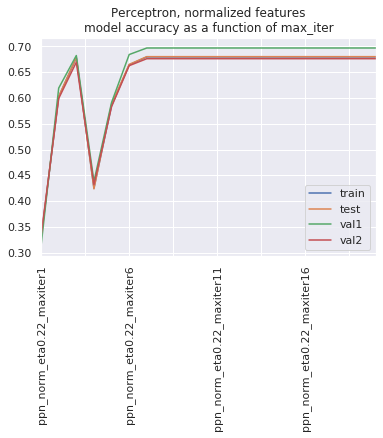

In [26]:
ppn_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Perceptron (normalized features)'
eta = 0.22
for max_iter in range(1, 21, 1):
    scores_name = 'ppn_norm_eta{0}_maxiter{1}'.format(eta, max_iter)
    ppn = Perceptron(max_iter=max_iter, eta0=eta, random_state=1)
    ppn_norm_scores_df.loc[scores_name] = \
        fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
ppn_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Perceptron, normalized features\nmodel accuracy as a function of max_iter");

##### Best model performance

In [27]:
model_name = 'Perceptron (normalized features)'
eta = 0.22
max_iter = 7
scores_name = 'ppn_norm_eta{0}_maxiter{1}'.format(eta, max_iter)
ppn = Perceptron(max_iter=max_iter, eta0=eta, random_state=1)
scores_df.loc[scores_name] = \
    fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True)


Perceptron (normalized features) fit, took 0.40 seconds (0.01 minutes)
accuracy: train=0.68, test=0.68, validation #1=0.70, validation #2=0.68


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


#### Logistic regression

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

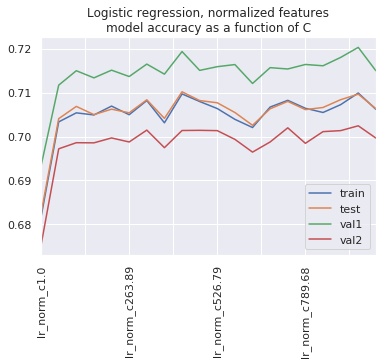

In [28]:
lr_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Logistic regression (normalized features)'
for c in np.round(np.linspace(1, 1000, 20), 2):
    scores_name = 'lr_norm_c{0}'.format(c)
    lr = LogisticRegression(C=c, random_state=1, solver='lbfgs', multi_class='auto', max_iter=150)
    lr_norm_scores_df.loc[scores_name] = \
        fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
lr_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Logistic regression, normalized features\nmodel accuracy as a function of C");

In [29]:
mask1 = lr_norm_scores_df['val1'] > 0.69
lr_norm_scores_df[mask1]

,train,test,val1,val2
lr_norm_c1.0,0.681700,0.682497,0.693339,0.675288
lr_norm_c53.58,0.703335,0.704069,0.711705,0.697208
lr_norm_c106.16,0.705396,0.706863,0.714990,0.698595
lr_norm_c158.74,0.704917,0.704992,0.713365,0.698565
lr_norm_c211.32,0.706937,0.706231,0.715118,0.699680
lr_norm_c263.89,0.704969,0.705405,0.713671,0.698761
lr_norm_c316.47,0.708197,0.708369,0.716501,0.701467
lr_norm_c369.05,0.703126,0.704142,0.714210,0.697464
lr_norm_c421.63,0.709706,0.710191,0.719360,0.701376
lr_norm_c474.21,0.707978,0.708199,0.715068,0.701414


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


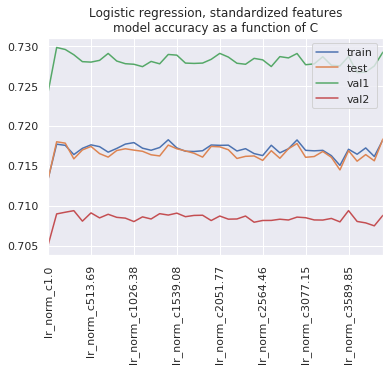

In [30]:
lr_std_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Logistic regression (standardized features)'
for c in np.round(np.linspace(1, 4000, 40), 2):
    scores_name = 'lr_norm_c{0}'.format(c)
    lr = LogisticRegression(C=c, random_state=1, solver='lbfgs', multi_class='auto', max_iter=150)
    lr_std_scores_df.loc[scores_name] = \
        fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                  return_scores=True, verbose=False)
lr_std_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Logistic regression, standardized features\nmodel accuracy as a function of C");

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

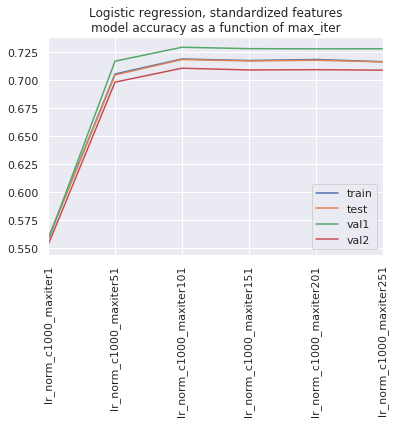

In [31]:
lr_std_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Logistic regression (standardized features)'
c = 1000
for max_iter in range(1, 301, 50):
    scores_name = 'lr_norm_c{0}_maxiter{1}'.format(c, max_iter)
    lr = LogisticRegression(C=c, random_state=1, solver='lbfgs', multi_class='auto', max_iter=max_iter)
    lr_std_scores_df.loc[scores_name] = \
        fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                  return_scores=True, verbose=False)
lr_std_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Logistic regression, standardized features\nmodel accuracy as a function of max_iter");

##### Best model performance

In [32]:
model_name = 'Logistic regression (standardized features)'
c = 1000
max_iter = 150
scores_name = 'lr_std_c{0}_maxiter{1}'.format(c, max_iter)

lr = LogisticRegression(C=c, random_state=1, solver='lbfgs', multi_class='auto', max_iter=max_iter)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
              return_scores=True, verbose=False)

lr = LogisticRegression(C=c, random_state=1, solver='lbfgs', multi_class='auto', max_iter=max_iter)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=labels_list)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (standardized features) fit, took 7.51 seconds (0.13 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.73, validation #2=0.71


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_' + feat_set_name + '_feats_norm_coefs.png'
            .format(model_name), dpi=300, bbox_inches='tight')

#### Logistic regression with L1 regularization

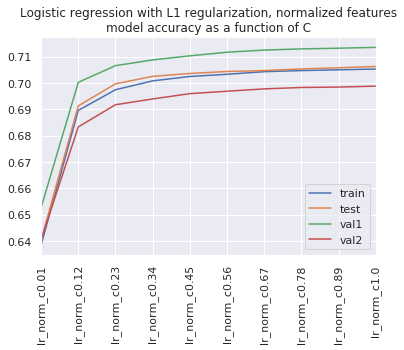

In [54]:
lr_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Logistic regression with L1 regularization (normalized features)'
for c in np.round(np.linspace(0.01, 1, 10), 2):
    scores_name = 'lr_norm_c{0}'.format(c)
    lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=150)
    lr_norm_scores_df.loc[scores_name] = \
        fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
lr_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Logistic regression with L1 regularization, normalized features\nmodel accuracy as a function of C");

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear f

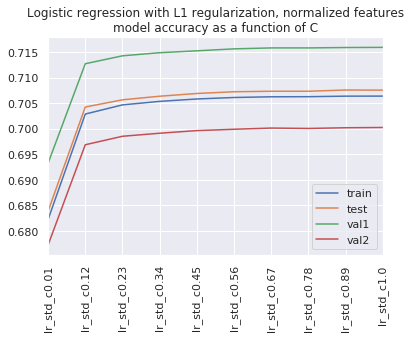

In [56]:
lr_std_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Logistic regression with L1 regularization (standardized features)'
for c in np.round(np.linspace(0.01, 1, 10), 2):
    scores_name = 'lr_std_c{0}'.format(c)
    lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=150)
    lr_std_scores_df.loc[scores_name] = \
        fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                  return_scores=True, verbose=False)
lr_std_scores_df.plot()
plt.xticks(rotation=90)
plt.title("Logistic regression with L1 regularization, normalized features\nmodel accuracy as a function of C");

##### Best model performance

In [57]:
model_name = 'Logistic regression with L1 regularization (normalized features)'
c = 1.0
max_iter = 50
scores_name = 'lr_l1_norm_c{0}_maxiter{1}'.format(c, max_iter)

lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=max_iter)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True, verbose=False)

lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=max_iter)
lr_coef = fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=labels_list)


Logistic regression with L1 regularization (normalized features) fit, took 24.01 seconds (0.40 minutes)
accuracy: train=0.71, test=0.71, validation #1=0.71, validation #2=0.70


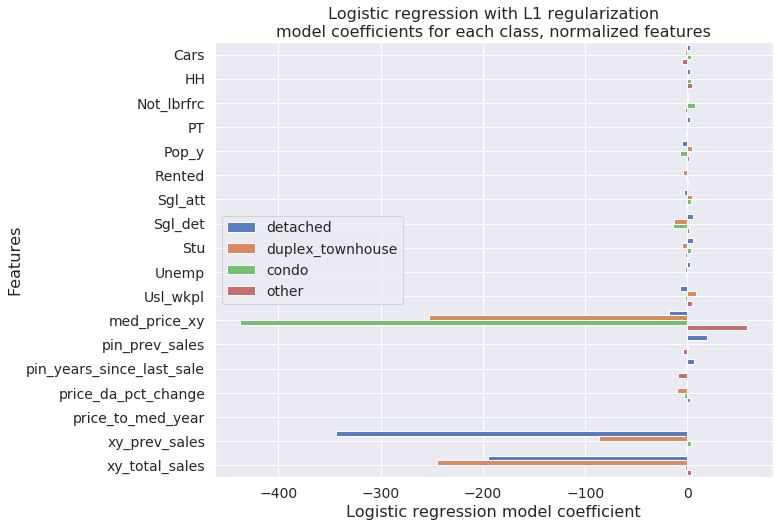

In [58]:
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression with L1 regularization\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_' + feat_set_name + '_feats_norm_coefs.png'
            .format(scores_name), dpi=300, bbox_inches='tight')

#### Decision Tree

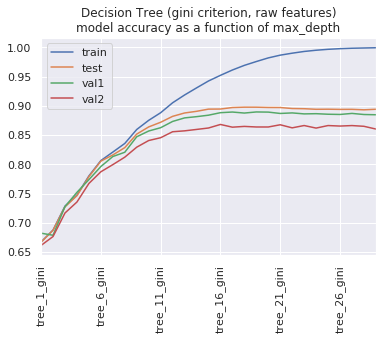

In [40]:
tree_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
criterion = 'gini'
model_name = 'Decision Tree ({0} criterion, raw features)'.format(criterion)
for max_depth in range(1, 30):
    scores_name = 'tree_{0}_{1}'.format(max_depth, criterion)
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
    tree_scores_df.loc[scores_name] = \
        fit_model(tree, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
tree_scores_df.plot()
plt.xticks(rotation=90)
plt.title("{0}\nmodel accuracy as a function of max_depth".format(model_name));

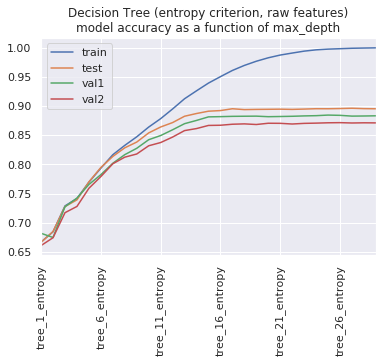

In [41]:
tree_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
criterion = 'entropy'
model_name = 'Decision Tree ({0} criterion, raw features)'.format(criterion)
for max_depth in range(1, 30):
    scores_name = 'tree_{0}_{1}'.format(max_depth, criterion)
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
    tree_scores_df.loc[scores_name] = \
        fit_model(tree, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
tree_scores_df.plot()
plt.xticks(rotation=90)
plt.title("{0}\nmodel accuracy as a function of max_depth".format(model_name));

##### Best model performance

In [63]:
# set model name and hyperparameters
max_depth = 16
criterion = 'gini'
model_name = 'Decision Tree ({0} criterion, raw features)'.format(criterion)
scores_name = 'tree_raw_{0}_{1}'.format(criterion, max_depth)

# get best model scores
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
scores_df.loc[scores_name] = \
    fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)

# visualize decision tree
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=labels_list,
                           feature_names=feat_cols, 
                           out_file='../../results/{0}_' + feat_set_name + '_features.dot'.format(scores_name))



# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')


Decision Tree (gini criterion, raw features) fit, took 1.74 seconds (0.03 minutes)
accuracy: train=0.95, test=0.89, validation #1=0.89, validation #2=0.87


#### Random Forest

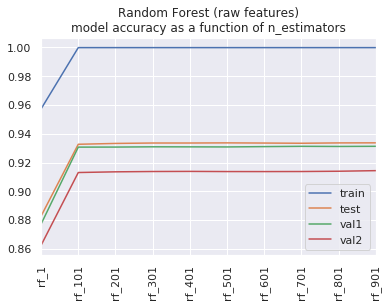

In [43]:
rf_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Random Forest (raw features)'
for n_trees in range(1, 1001, 100):
    scores_name = 'rf_{0}'.format(n_trees)
    forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
    rf_scores_df.loc[scores_name] = \
        fit_model(forest, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
rf_scores_df.plot()
plt.xticks(rotation=90)
plt.title("{0}\nmodel accuracy as a function of n_estimators".format(model_name));

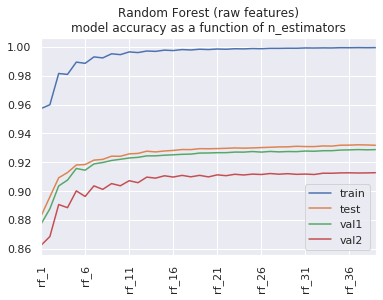

In [44]:
rf_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'Random Forest (raw features)'
for n_trees in range(1, 40, 1):
    scores_name = 'rf_{0}'.format(n_trees)
    forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
    rf_scores_df.loc[scores_name] = \
        fit_model(forest, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
rf_scores_df.plot()
plt.xticks(rotation=90)
plt.title("{0}\nmodel accuracy as a function of n_estimators".format(model_name));

##### Best model performance

In [45]:
# set model name and hyperparameters
n_trees = 16
criterion = 'gini'
scores_name = 'forest_raw_{0}_{1}'.format(criterion, max_depth)

# get best model scores
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
scores_df.loc[scores_name] = \
    fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)


Random Forest (raw features) fit, took 1.61 seconds (0.03 minutes)
accuracy: train=1.00, test=0.93, validation #1=0.92, validation #2=0.90


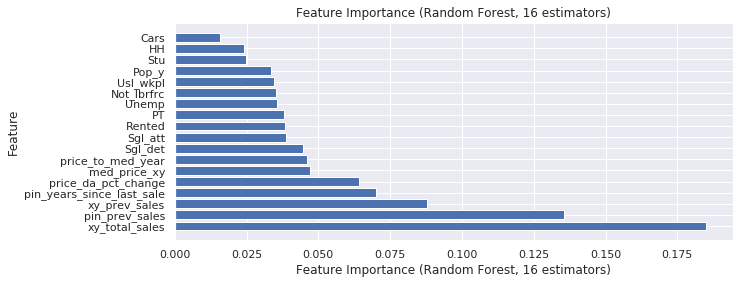

In [46]:
# fit Random Forest model
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_trees)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
forest.score(X_val1, y_val1)

# plot feature importances from Random Forest
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
ax.set_ylabel('Feature')
f.savefig('../../results/plots/rf{0}_' + feat_set_name + '_feature_importance.png'.format(n_trees), dpi=300)

#### K-nearest neighbors

##### Raw features, Manhattan distance

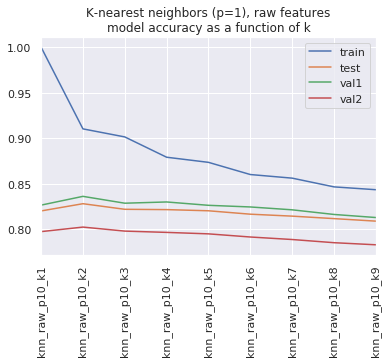

In [47]:
knn_raw_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'K-nearest neighbors (raw features)'
p = 1
for k in range(1, 10):
    scores_name = 'knn_raw_p{0}_k{1}'.format(c, k)
    knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    knn_raw_scores_df.loc[scores_name] = \
        fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
                  return_scores=True, verbose=False)
knn_raw_scores_df.plot()
plt.xticks(rotation=90)
plt.title("K-nearest neighbors (p={0}), raw features\nmodel accuracy as a function of k".format(p));

##### Raw features, Euclidean distance

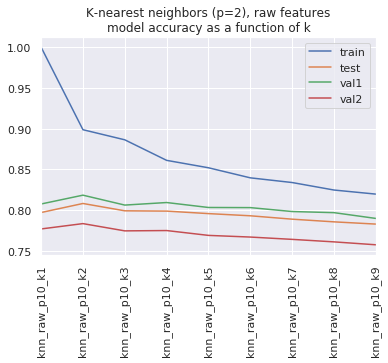

In [48]:
knn_raw_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'K-nearest neighbors (raw features)'
p = 2
for k in range(1, 10):
    scores_name = 'knn_raw_p{0}_k{1}'.format(c, k)
    knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    knn_raw_scores_df.loc[scores_name] = \
        fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
                  return_scores=True, verbose=False)
knn_raw_scores_df.plot()
plt.xticks(rotation=90)
plt.title("K-nearest neighbors (p={0}), raw features\nmodel accuracy as a function of k".format(p));

##### Normalized features, Manhattan distance

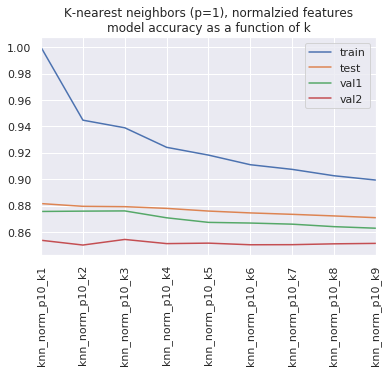

In [49]:
knn_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'K-nearest neighbors (normalized  features)'
p = 1
for k in range(1, 10):
    scores_name = 'knn_norm_p{0}_k{1}'.format(c, k)
    knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    knn_norm_scores_df.loc[scores_name] = \
        fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
knn_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("K-nearest neighbors (p={0}), normalzied features\nmodel accuracy as a function of k".format(p));

##### Normalized features, Euclidean distance

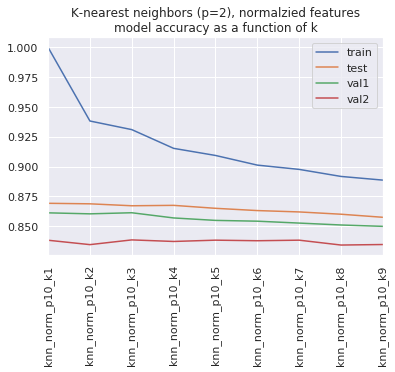

In [50]:
knn_norm_scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])
model_name = 'K-nearest neighbors (normalized  features)'
p = 2
for k in range(1, 10):
    scores_name = 'knn_norm_p{0}_k{1}'.format(c, k)
    knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    knn_norm_scores_df.loc[scores_name] = \
        fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
                  return_scores=True, verbose=False)
knn_norm_scores_df.plot()
plt.xticks(rotation=90)
plt.title("K-nearest neighbors (p={0}), normalzied features\nmodel accuracy as a function of k".format(p));

##### Best model performance

In [51]:
k = 4
p = 1
model_name = 'K-nearest neighbors, k={0}, p={1} (normalized  features)'.format(k, p)
scores_name = 'knn_norm_k{0}_p{1}'.format(k, p)

knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
scores_df.loc[scores_name] = \
    fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True)


K-nearest neighbors, k=4, p=1 (normalized  features) fit, took 120.00 seconds (2.00 minutes)
accuracy: train=0.92, test=0.88, validation #1=0.87, validation #2=0.85


## Compare perfomance of models

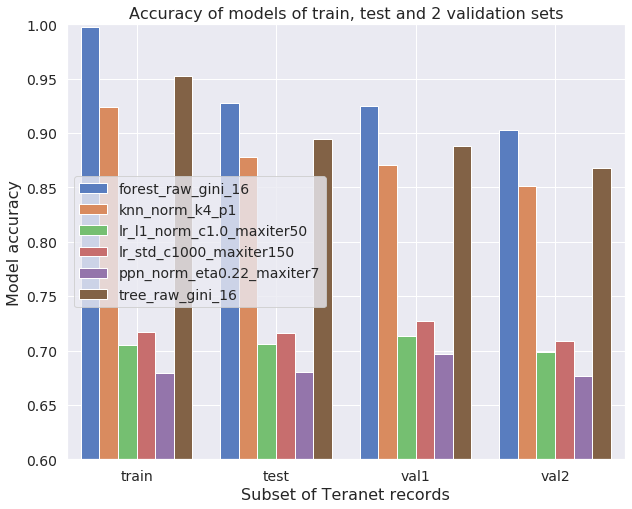

In [66]:
scores_tidy = scores_df.reset_index().rename(columns={'index': 'model'})\
                       .melt(id_vars='model', var_name='subset', value_name='score').sort_values(['model', 'subset'])

f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="subset", y="score", hue="model", order=['train', 'test', 'val1', 'val2'],
                                                       data=scores_tidy, palette="muted", ax=ax)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xlabel("Subset of Teranet records", fontsize=16)
ax.set_title("Accuracy of models of train, test and 2 validation sets", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0.6, 1.0)
plt.savefig('../../results/plots/model_performance_' + feat_set_name + '.png'
            .format(model_name), dpi=300, bbox_inches='tight')